In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.utils as vutils
from PIL import Image
import numpy as np

In [2]:
data_dir = "C:\\Users\İdris Aydın\\Desktop\\flowers\\train_flower"

In [3]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [4]:
class FlowersDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.image_files = [file for file in os.listdir(root_dir) if file.endswith(('jpg', 'jpeg', 'png'))]
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_path)  # Burada resmi yükle

        if self.transform:
            image = self.transform(image)

        return image

In [5]:
dataset = FlowersDataset(data_dir, transform=transform)

In [6]:
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

In [7]:
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()

        self.main = nn.Sequential(
            nn.Linear(nz, 128),
            nn.ReLU(True),
            nn.BatchNorm1d(128),

            nn.Linear(128, 256),
            nn.ReLU(True),
            nn.BatchNorm1d(256),

            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.BatchNorm1d(512),

            nn.Linear(512, 1024),
            nn.ReLU(True),
            nn.BatchNorm1d(1024),

            nn.Linear(1024, 3 * 128 * 128),
            nn.Tanh()
        )

    def forward(self, z):
        return self.main(z).view(-1, 3, 128, 128)

In [8]:
class Discriminator(nn.Module):
    def __init__(self):
       super(Discriminator, self).__init__()

       self.main = nn.Sequential(
            nn.Linear(3 * 128 * 128, 1024),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.2),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.2),
            
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.2),
            
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        return self.main(img.view(-1, 3 * 128 * 128))

In [13]:
nz = 256
lr_generator = 0.0001
lr_discriminator = 0.02
beta1 = 0.5
num_epochs = 360

In [14]:
generator = Generator(nz)
discriminator = Discriminator()

In [15]:
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr_generator, betas=(beta1, 0.999))
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr_discriminator, betas=(beta1, 0.999))

In [16]:
criterion = nn.BCELoss()

In [17]:
num_show_images = 5

[0/360][67/68] Loss_D: 0.9655 Loss_G: 1.4023


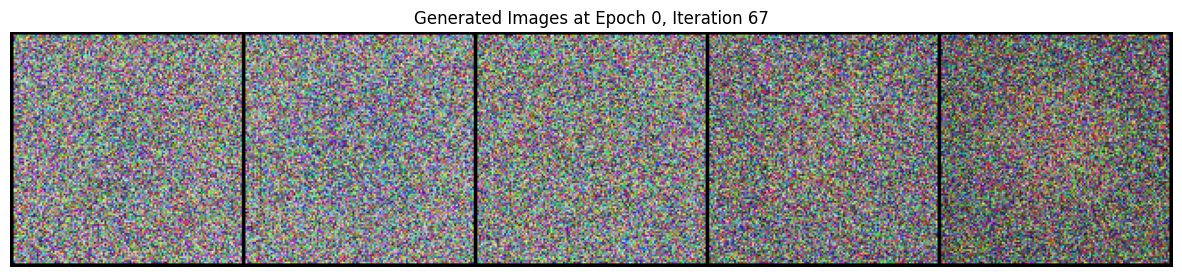

[10/360][67/68] Loss_D: 0.2760 Loss_G: 6.2664


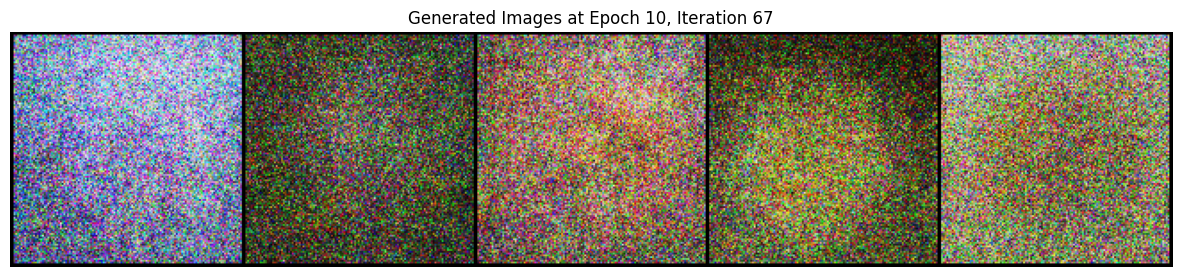

[20/360][67/68] Loss_D: 3.9189 Loss_G: 1.3196


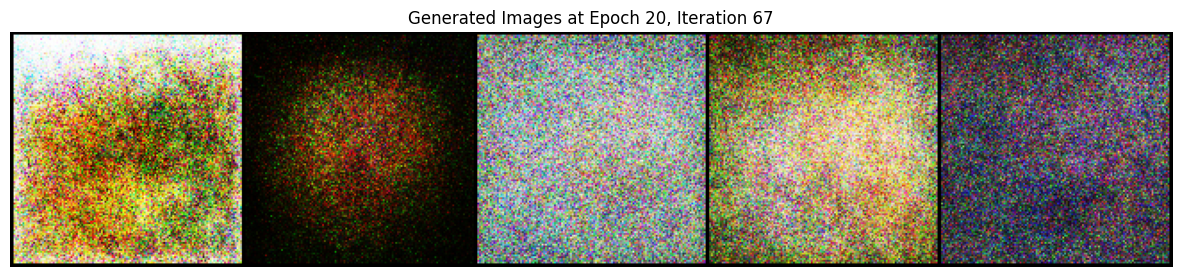

In [ ]:
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader):

        discriminator.zero_grad()

        real_images = data.to("cpu")
        b_size = real_images.size(0)

        labels = torch.full((b_size,), 1., dtype=torch.float)

        output = discriminator(real_images).view(-1)
        lossD_real = criterion(output, labels)
        lossD_real.backward()

        noise = torch.randn(b_size, nz)
        fake_images = generator(noise)

        labels.fill_(0.)

        output = discriminator(fake_images.detach()).view(-1)
        lossD_fake = criterion(output, labels)
        lossD_fake.backward()

        lossD = lossD_real + lossD_fake
        optimizer_discriminator.step()
        #-------------------------------------------------------------------------------------

        #-------------------------------------------------------------------------------------

        generator.zero_grad()
        labels.fill_(1.)  
        output = discriminator(fake_images).view(-1)
        lossG = criterion(output, labels)
        lossG.backward()
        optimizer_generator.step()

    if epoch % 10 == 0:
        print(f'[{epoch}/{num_epochs}][{i}/{len(dataloader)}] '
             f'Loss_D: {lossD.item():.4f} Loss_G: {lossG.item():.4f}')

        with torch.no_grad():
            noise = torch.randn(num_show_images, nz)
            fake_images = generator(noise).detach().cpu()

            grid = vutils.make_grid(fake_images, nrow=num_show_images, normalize=True)
            plt.figure(figsize=(15, 5))
            plt.imshow(grid.permute(1, 2, 0))
            plt.title(f'Generated Images at Epoch {epoch}, Iteration {i}')
            plt.axis('off')
            plt.show()